In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


In [2]:
# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100

In [3]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [4]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [5]:
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [6]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [7]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [8]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [14]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = int(x_train.shape[0] / batch_size)

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    #for e in xrange(1, epochs+1):
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        #for _ in tqdm(xrange(batch_count)):
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

--------------- Epoch 1 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.73it/s]


--------------- Epoch 2 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:00<00:00,  7.35it/s]


--------------- Epoch 3 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.53it/s]


--------------- Epoch 4 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.60it/s]


--------------- Epoch 5 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.57it/s]


--------------- Epoch 6 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00,  9.93it/s]


--------------- Epoch 7 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00,  9.91it/s]


--------------- Epoch 8 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:49<00:00,  8.64it/s]


--------------- Epoch 9 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:52<00:00,  8.26it/s]


--------------- Epoch 10 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:53<00:00,  8.75it/s]


--------------- Epoch 11 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:52<00:00,  8.88it/s]


--------------- Epoch 12 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:49<00:00,  7.12it/s]


--------------- Epoch 13 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  7.62it/s]


--------------- Epoch 14 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 10.08it/s]


--------------- Epoch 15 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 10.31it/s]


--------------- Epoch 16 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:45<00:00, 10.31it/s]


--------------- Epoch 17 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:45<00:00, 10.28it/s]


--------------- Epoch 18 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:45<00:00, 10.24it/s]


--------------- Epoch 19 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:45<00:00, 10.29it/s]


--------------- Epoch 20 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  9.96it/s]


--------------- Epoch 21 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00,  9.99it/s]


--------------- Epoch 22 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  8.65it/s]


--------------- Epoch 23 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00, 10.37it/s]


--------------- Epoch 24 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.89it/s]


--------------- Epoch 25 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00, 10.43it/s]


--------------- Epoch 26 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  8.77it/s]


--------------- Epoch 27 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:52<00:00,  9.21it/s]


--------------- Epoch 28 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:52<00:00,  9.39it/s]


--------------- Epoch 29 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00, 10.35it/s]


--------------- Epoch 30 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.94it/s]


--------------- Epoch 31 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 10.02it/s]


--------------- Epoch 32 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.93it/s]


--------------- Epoch 33 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00,  9.95it/s]


--------------- Epoch 34 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00,  9.81it/s]


--------------- Epoch 35 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 10.02it/s]


--------------- Epoch 36 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00, 10.43it/s]


--------------- Epoch 37 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 10.12it/s]


--------------- Epoch 38 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00,  9.83it/s]


--------------- Epoch 39 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00,  9.80it/s]


--------------- Epoch 40 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 10.13it/s]


--------------- Epoch 41 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.79it/s]


--------------- Epoch 42 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 10.24it/s]


--------------- Epoch 43 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00,  9.89it/s]


--------------- Epoch 44 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.94it/s]


--------------- Epoch 45 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.82it/s]


--------------- Epoch 46 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00, 10.17it/s]


--------------- Epoch 47 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:55<00:00,  8.55it/s]


--------------- Epoch 48 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.62it/s]


--------------- Epoch 49 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:49<00:00, 10.03it/s]


--------------- Epoch 50 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:49<00:00, 10.25it/s]


--------------- Epoch 51 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00,  9.41it/s]


--------------- Epoch 52 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.69it/s]


--------------- Epoch 53 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:52<00:00,  8.88it/s]


--------------- Epoch 54 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:49<00:00,  9.34it/s]


--------------- Epoch 55 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  7.32it/s]


--------------- Epoch 56 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.36it/s]


--------------- Epoch 57 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  8.63it/s]


--------------- Epoch 58 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:49<00:00,  8.38it/s]


--------------- Epoch 59 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 10.16it/s]


--------------- Epoch 60 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:45<00:00, 10.26it/s]


--------------- Epoch 61 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:45<00:00, 10.39it/s]


--------------- Epoch 62 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:53<00:00, 10.06it/s]


--------------- Epoch 63 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:51<00:00,  8.57it/s]


--------------- Epoch 64 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.66it/s]


--------------- Epoch 65 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00,  9.39it/s]


--------------- Epoch 66 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:49<00:00, 10.02it/s]


--------------- Epoch 67 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.55it/s]


--------------- Epoch 68 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:53<00:00,  7.39it/s]


--------------- Epoch 69 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 10.06it/s]


--------------- Epoch 70 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:52<00:00,  7.53it/s]


--------------- Epoch 71 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:00<00:00,  9.10it/s]


--------------- Epoch 72 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 10.06it/s]


--------------- Epoch 73 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:52<00:00,  8.65it/s]


--------------- Epoch 74 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:55<00:00,  7.94it/s]


--------------- Epoch 75 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  8.54it/s]


--------------- Epoch 76 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.63it/s]


--------------- Epoch 77 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00,  9.34it/s]


--------------- Epoch 78 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  7.35it/s]


--------------- Epoch 79 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00, 10.17it/s]


--------------- Epoch 80 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00,  9.47it/s]


--------------- Epoch 81 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00,  7.41it/s]


--------------- Epoch 82 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:59<00:00,  8.44it/s]


--------------- Epoch 83 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  8.57it/s]


--------------- Epoch 84 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:00<00:00,  6.78it/s]


--------------- Epoch 85 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:58<00:00,  9.80it/s]


--------------- Epoch 86 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:59<00:00,  8.94it/s]


--------------- Epoch 87 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  7.48it/s]


--------------- Epoch 88 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:57<00:00,  8.73it/s]


--------------- Epoch 89 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:55<00:00,  8.21it/s]


--------------- Epoch 90 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00,  9.31it/s]


--------------- Epoch 91 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:51<00:00,  9.22it/s]


--------------- Epoch 92 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00,  9.42it/s]


--------------- Epoch 93 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:58<00:00,  8.31it/s]


--------------- Epoch 94 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:51<00:00,  9.06it/s]


--------------- Epoch 95 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:49<00:00,  9.46it/s]


--------------- Epoch 96 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.56it/s]


--------------- Epoch 97 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.56it/s]


--------------- Epoch 98 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.35it/s]


--------------- Epoch 99 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00,  9.97it/s]


--------------- Epoch 100 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:53<00:00,  8.72it/s]


--------------- Epoch 101 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.63it/s]


--------------- Epoch 102 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:52<00:00, 10.09it/s]


--------------- Epoch 103 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.41it/s]


--------------- Epoch 104 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.48it/s]


--------------- Epoch 105 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00,  9.70it/s]


--------------- Epoch 106 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:49<00:00,  8.26it/s]


--------------- Epoch 107 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:45<00:00, 10.25it/s]


--------------- Epoch 108 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  7.42it/s]


--------------- Epoch 109 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.49it/s]


--------------- Epoch 110 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.60it/s]


--------------- Epoch 111 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.54it/s]


--------------- Epoch 112 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.69it/s]


--------------- Epoch 113 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.62it/s]


--------------- Epoch 114 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.79it/s]


--------------- Epoch 115 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.51it/s]


--------------- Epoch 116 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  9.66it/s]


--------------- Epoch 117 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.63it/s]


--------------- Epoch 118 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:49<00:00,  8.72it/s]


--------------- Epoch 119 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.78it/s]


--------------- Epoch 120 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:51<00:00,  6.81it/s]


--------------- Epoch 121 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:58<00:00,  8.09it/s]


--------------- Epoch 122 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  9.87it/s]


--------------- Epoch 123 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00,  7.82it/s]


--------------- Epoch 124 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00,  9.67it/s]


--------------- Epoch 125 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  8.09it/s]


--------------- Epoch 126 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:58<00:00,  6.54it/s]


--------------- Epoch 127 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:53<00:00, 10.00it/s]


--------------- Epoch 128 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.79it/s]


--------------- Epoch 129 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:51<00:00,  9.01it/s]


--------------- Epoch 130 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:49<00:00,  9.30it/s]


--------------- Epoch 131 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:51<00:00,  9.48it/s]


--------------- Epoch 132 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00, 10.08it/s]


--------------- Epoch 133 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.93it/s]


--------------- Epoch 134 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00, 10.10it/s]


--------------- Epoch 135 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00,  9.33it/s]


--------------- Epoch 136 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:51<00:00,  8.81it/s]


--------------- Epoch 137 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:59<00:00,  8.13it/s]


--------------- Epoch 138 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  9.65it/s]


--------------- Epoch 139 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.52it/s]


--------------- Epoch 140 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00,  8.27it/s]


--------------- Epoch 141 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:52<00:00, 10.05it/s]


--------------- Epoch 142 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:52<00:00,  8.84it/s]


--------------- Epoch 143 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.83it/s]


--------------- Epoch 144 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00,  9.77it/s]


--------------- Epoch 145 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00, 10.24it/s]


--------------- Epoch 146 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00, 10.03it/s]


--------------- Epoch 147 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.55it/s]


--------------- Epoch 148 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.80it/s]


--------------- Epoch 149 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00, 10.05it/s]


--------------- Epoch 150 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.95it/s]


--------------- Epoch 151 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:51<00:00, 10.32it/s]


--------------- Epoch 152 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.74it/s]


--------------- Epoch 153 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.94it/s]


--------------- Epoch 154 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:55<00:00,  8.38it/s]


--------------- Epoch 155 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00, 10.33it/s]


--------------- Epoch 156 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00, 10.31it/s]


--------------- Epoch 157 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 10.33it/s]


--------------- Epoch 158 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.70it/s]


--------------- Epoch 159 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:45<00:00, 10.38it/s]


--------------- Epoch 160 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:55<00:00,  7.67it/s]


--------------- Epoch 161 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.76it/s]


--------------- Epoch 162 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:00<00:00,  7.79it/s]


--------------- Epoch 163 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.73it/s]


--------------- Epoch 164 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.80it/s]


--------------- Epoch 165 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:00<00:00,  7.39it/s]


--------------- Epoch 166 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.62it/s]


--------------- Epoch 167 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:58<00:00,  8.81it/s]


--------------- Epoch 168 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:58<00:00,  7.85it/s]


--------------- Epoch 169 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:53<00:00,  9.68it/s]


--------------- Epoch 170 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.47it/s]


--------------- Epoch 171 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.88it/s]


--------------- Epoch 172 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00,  9.98it/s]


--------------- Epoch 173 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:53<00:00,  7.29it/s]


--------------- Epoch 174 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00,  9.57it/s]


--------------- Epoch 175 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:52<00:00,  8.98it/s]


--------------- Epoch 176 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00,  9.96it/s]


--------------- Epoch 177 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:58<00:00,  6.68it/s]


--------------- Epoch 178 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.93it/s]


--------------- Epoch 179 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:19<00:00,  6.23it/s]


--------------- Epoch 180 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:16<00:00,  6.57it/s]


--------------- Epoch 181 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:17<00:00,  5.59it/s]


--------------- Epoch 182 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:19<00:00,  5.80it/s]


--------------- Epoch 183 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:15<00:00,  5.74it/s]


--------------- Epoch 184 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:19<00:00,  4.40it/s]


--------------- Epoch 185 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:21<00:00,  5.98it/s]


--------------- Epoch 186 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:18<00:00,  4.93it/s]


--------------- Epoch 187 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:17<00:00,  7.20it/s]


--------------- Epoch 188 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.42it/s]


--------------- Epoch 189 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:58<00:00,  8.81it/s]


--------------- Epoch 190 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:51<00:00,  9.42it/s]


--------------- Epoch 191 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:52<00:00,  7.21it/s]


--------------- Epoch 192 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  7.13it/s]


--------------- Epoch 193 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:57<00:00,  7.45it/s]


--------------- Epoch 194 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  9.12it/s]


--------------- Epoch 195 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:52<00:00,  9.41it/s]


--------------- Epoch 196 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:53<00:00,  7.52it/s]


--------------- Epoch 197 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:56<00:00,  9.00it/s]


--------------- Epoch 198 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:57<00:00,  8.81it/s]


--------------- Epoch 199 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:55<00:00,  9.06it/s]


--------------- Epoch 200 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:57<00:00,  8.16it/s]


--------------- Epoch 201 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:57<00:00,  8.75it/s]


--------------- Epoch 202 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:55<00:00,  8.77it/s]


--------------- Epoch 203 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  7.01it/s]


--------------- Epoch 204 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:55<00:00,  9.32it/s]


--------------- Epoch 205 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:51<00:00,  9.59it/s]


--------------- Epoch 206 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.71it/s]


--------------- Epoch 207 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 10.12it/s]


--------------- Epoch 208 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.78it/s]


--------------- Epoch 209 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:51<00:00, 10.29it/s]


--------------- Epoch 210 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.86it/s]


--------------- Epoch 211 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00, 10.29it/s]


--------------- Epoch 212 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:51<00:00,  9.06it/s]


--------------- Epoch 213 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:45<00:00, 10.15it/s]


--------------- Epoch 214 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:59<00:00,  7.47it/s]


--------------- Epoch 215 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.16it/s]


--------------- Epoch 216 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:04<00:00,  7.03it/s]


--------------- Epoch 217 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.62it/s]


--------------- Epoch 218 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.54it/s]


--------------- Epoch 219 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.31it/s]


--------------- Epoch 220 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.82it/s]


--------------- Epoch 221 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.60it/s]


--------------- Epoch 222 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.82it/s]


--------------- Epoch 223 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.63it/s]


--------------- Epoch 224 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.42it/s]


--------------- Epoch 225 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.57it/s]


--------------- Epoch 226 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.56it/s]


--------------- Epoch 227 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.65it/s]


--------------- Epoch 228 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  6.68it/s]


--------------- Epoch 229 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.33it/s]


--------------- Epoch 230 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.38it/s]


--------------- Epoch 231 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.33it/s]


--------------- Epoch 232 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:51<00:00, 10.23it/s]


--------------- Epoch 233 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 10.00it/s]


--------------- Epoch 234 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.86it/s]


--------------- Epoch 235 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00, 10.27it/s]


--------------- Epoch 236 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00,  9.10it/s]


--------------- Epoch 237 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00,  9.99it/s]


--------------- Epoch 238 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.98it/s]


--------------- Epoch 239 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:50<00:00, 10.22it/s]


--------------- Epoch 240 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00, 10.36it/s]


--------------- Epoch 241 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  7.13it/s]


--------------- Epoch 242 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.64it/s]


--------------- Epoch 243 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.58it/s]


--------------- Epoch 244 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.74it/s]


--------------- Epoch 245 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.29it/s]


--------------- Epoch 246 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.55it/s]


--------------- Epoch 247 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.72it/s]


--------------- Epoch 248 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:00<00:00,  7.90it/s]


--------------- Epoch 249 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.87it/s]


--------------- Epoch 250 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:00<00:00,  7.65it/s]


--------------- Epoch 251 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.44it/s]


--------------- Epoch 252 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.70it/s]


--------------- Epoch 253 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.75it/s]


--------------- Epoch 254 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.44it/s]


--------------- Epoch 255 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.72it/s]


--------------- Epoch 256 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.66it/s]


--------------- Epoch 257 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.60it/s]


--------------- Epoch 258 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.41it/s]


--------------- Epoch 259 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.38it/s]


--------------- Epoch 260 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.64it/s]


--------------- Epoch 261 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.49it/s]


--------------- Epoch 262 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.66it/s]


--------------- Epoch 263 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.45it/s]


--------------- Epoch 264 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:01<00:00,  7.68it/s]


--------------- Epoch 265 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.58it/s]


--------------- Epoch 266 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:52<00:00,  7.49it/s]


--------------- Epoch 267 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:49<00:00, 10.50it/s]


--------------- Epoch 268 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:51<00:00,  8.04it/s]


--------------- Epoch 269 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.59it/s]


--------------- Epoch 270 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:49<00:00,  7.56it/s]


--------------- Epoch 271 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.46it/s]


--------------- Epoch 272 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:58<00:00,  6.95it/s]


--------------- Epoch 273 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:57<00:00,  9.07it/s]


--------------- Epoch 274 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:49<00:00,  9.44it/s]


--------------- Epoch 275 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  9.61it/s]


--------------- Epoch 276 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00,  8.77it/s]


--------------- Epoch 277 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  8.53it/s]


--------------- Epoch 278 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:57<00:00,  8.21it/s]


--------------- Epoch 279 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  8.67it/s]


--------------- Epoch 280 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:56<00:00,  7.22it/s]


--------------- Epoch 281 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:56<00:00,  6.66it/s]


--------------- Epoch 282 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  9.01it/s]


--------------- Epoch 283 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:55<00:00,  8.62it/s]


--------------- Epoch 284 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:57<00:00,  8.68it/s]


--------------- Epoch 285 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:56<00:00,  8.53it/s]


--------------- Epoch 286 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:53<00:00,  8.34it/s]


--------------- Epoch 287 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  7.09it/s]


--------------- Epoch 288 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:52<00:00,  9.36it/s]


--------------- Epoch 289 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00, 10.12it/s]


--------------- Epoch 290 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00,  9.79it/s]


--------------- Epoch 291 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:04<00:00,  7.43it/s]


--------------- Epoch 292 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.45it/s]


--------------- Epoch 293 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:04<00:00,  7.31it/s]


--------------- Epoch 294 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.29it/s]


--------------- Epoch 295 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.40it/s]


--------------- Epoch 296 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.32it/s]


--------------- Epoch 297 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:04<00:00,  7.26it/s]


--------------- Epoch 298 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:04<00:00,  7.41it/s]


--------------- Epoch 299 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.37it/s]


--------------- Epoch 300 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.45it/s]


--------------- Epoch 301 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.45it/s]


--------------- Epoch 302 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:04<00:00,  6.71it/s]


--------------- Epoch 303 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.34it/s]


--------------- Epoch 304 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.02it/s]


--------------- Epoch 305 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.18it/s]


--------------- Epoch 306 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.31it/s]


--------------- Epoch 307 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  6.69it/s]


--------------- Epoch 308 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:07<00:00,  6.03it/s]


--------------- Epoch 309 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:06<00:00,  7.58it/s]


--------------- Epoch 310 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.57it/s]


--------------- Epoch 311 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.27it/s]


--------------- Epoch 312 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:04<00:00,  7.36it/s]


--------------- Epoch 313 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.28it/s]


--------------- Epoch 314 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.43it/s]


--------------- Epoch 315 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.54it/s]


--------------- Epoch 316 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.26it/s]


--------------- Epoch 317 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.26it/s]


--------------- Epoch 318 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.51it/s]


--------------- Epoch 319 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.24it/s]


--------------- Epoch 320 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.26it/s]


--------------- Epoch 321 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:04<00:00,  7.13it/s]


--------------- Epoch 322 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.44it/s]


--------------- Epoch 323 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.24it/s]


--------------- Epoch 324 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:04<00:00,  7.51it/s]


--------------- Epoch 325 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.29it/s]


--------------- Epoch 326 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.40it/s]


--------------- Epoch 327 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.20it/s]


--------------- Epoch 328 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.37it/s]


--------------- Epoch 329 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.07it/s]


--------------- Epoch 330 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.29it/s]


--------------- Epoch 331 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:05<00:00,  7.16it/s]


--------------- Epoch 332 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.43it/s]


--------------- Epoch 333 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.33it/s]


--------------- Epoch 334 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.44it/s]


--------------- Epoch 335 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.46it/s]


--------------- Epoch 336 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:05<00:00,  7.49it/s]


--------------- Epoch 337 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.32it/s]


--------------- Epoch 338 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.42it/s]


--------------- Epoch 339 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.19it/s]


--------------- Epoch 340 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.55it/s]


--------------- Epoch 341 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.49it/s]


--------------- Epoch 342 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.42it/s]


--------------- Epoch 343 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.32it/s]


--------------- Epoch 344 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.35it/s]


--------------- Epoch 345 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.55it/s]


--------------- Epoch 346 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.54it/s]


--------------- Epoch 347 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.34it/s]


--------------- Epoch 348 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.53it/s]


--------------- Epoch 349 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.43it/s]


--------------- Epoch 350 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.45it/s]


--------------- Epoch 351 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.22it/s]


--------------- Epoch 352 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.54it/s]


--------------- Epoch 353 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.57it/s]


--------------- Epoch 354 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.58it/s]


--------------- Epoch 355 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.58it/s]


--------------- Epoch 356 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.51it/s]


--------------- Epoch 357 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.71it/s]


--------------- Epoch 358 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.58it/s]


--------------- Epoch 359 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.33it/s]


--------------- Epoch 360 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.24it/s]


--------------- Epoch 361 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.47it/s]


--------------- Epoch 362 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.37it/s]


--------------- Epoch 363 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.55it/s]


--------------- Epoch 364 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.53it/s]


--------------- Epoch 365 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.30it/s]


--------------- Epoch 366 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.55it/s]


--------------- Epoch 367 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.31it/s]


--------------- Epoch 368 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.00it/s]


--------------- Epoch 369 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.42it/s]


--------------- Epoch 370 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.51it/s]


--------------- Epoch 371 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.51it/s]


--------------- Epoch 372 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.43it/s]


--------------- Epoch 373 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.60it/s]


--------------- Epoch 374 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.49it/s]


--------------- Epoch 375 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.43it/s]


--------------- Epoch 376 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.35it/s]


--------------- Epoch 377 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  6.84it/s]


--------------- Epoch 378 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.61it/s]


--------------- Epoch 379 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.48it/s]


--------------- Epoch 380 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.54it/s]


--------------- Epoch 381 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.64it/s]


--------------- Epoch 382 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.60it/s]


--------------- Epoch 383 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.42it/s]


--------------- Epoch 384 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.36it/s]


--------------- Epoch 385 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.39it/s]


--------------- Epoch 386 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.49it/s]


--------------- Epoch 387 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.40it/s]


--------------- Epoch 388 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.56it/s]


--------------- Epoch 389 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.39it/s]


--------------- Epoch 390 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  7.44it/s]


--------------- Epoch 391 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.49it/s]


--------------- Epoch 392 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:04<00:00,  7.49it/s]


--------------- Epoch 393 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:04<00:00,  7.55it/s]


--------------- Epoch 394 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.45it/s]


--------------- Epoch 395 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.36it/s]


--------------- Epoch 396 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.09it/s]


--------------- Epoch 397 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.47it/s]


--------------- Epoch 398 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.26it/s]


--------------- Epoch 399 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.22it/s]


--------------- Epoch 400 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [01:03<00:00,  7.35it/s]
C:\Users\Matthew\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


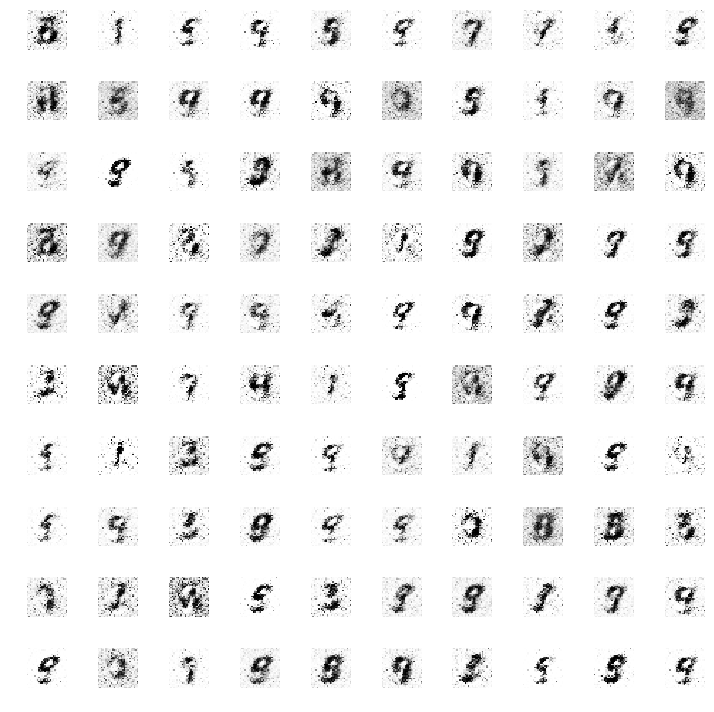

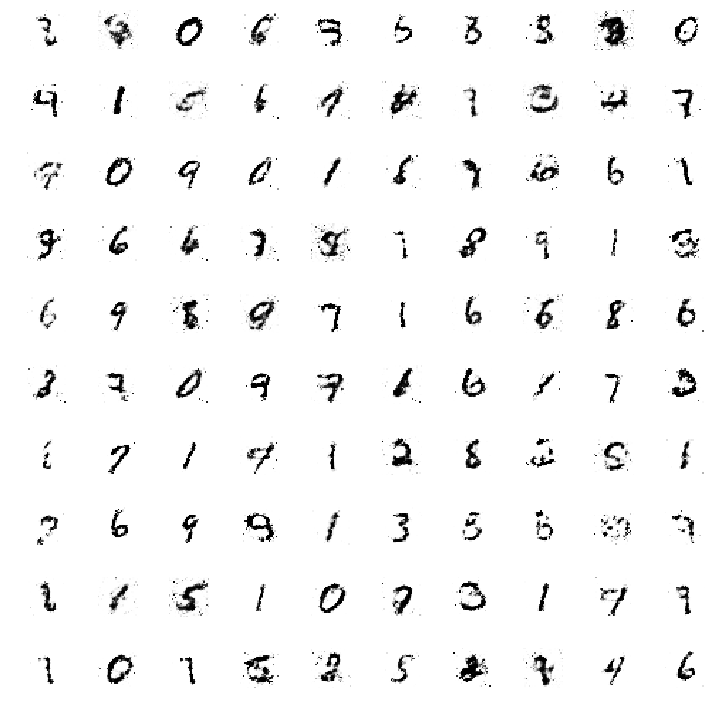

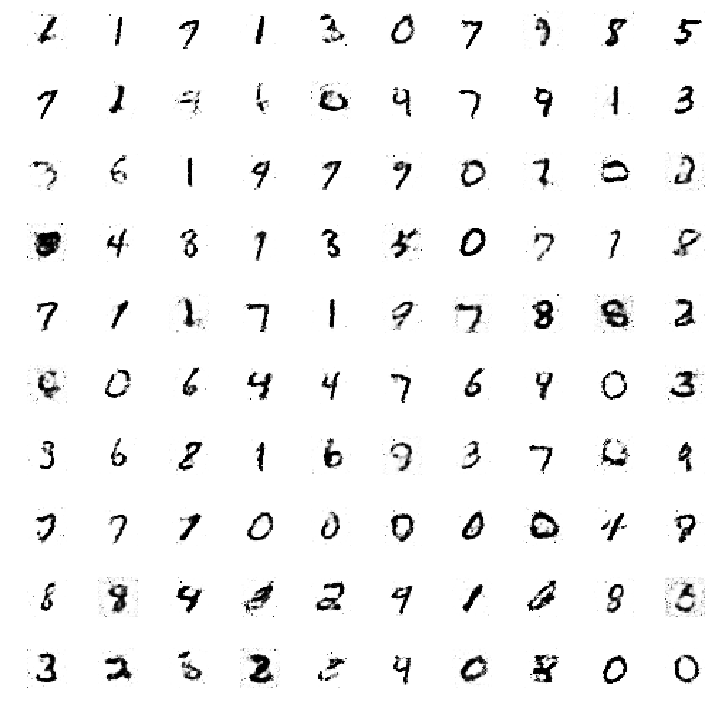

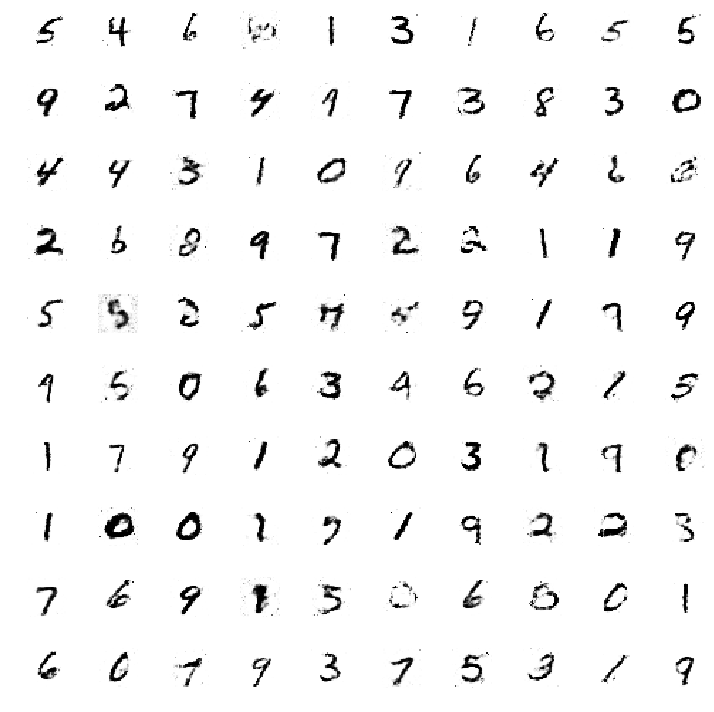

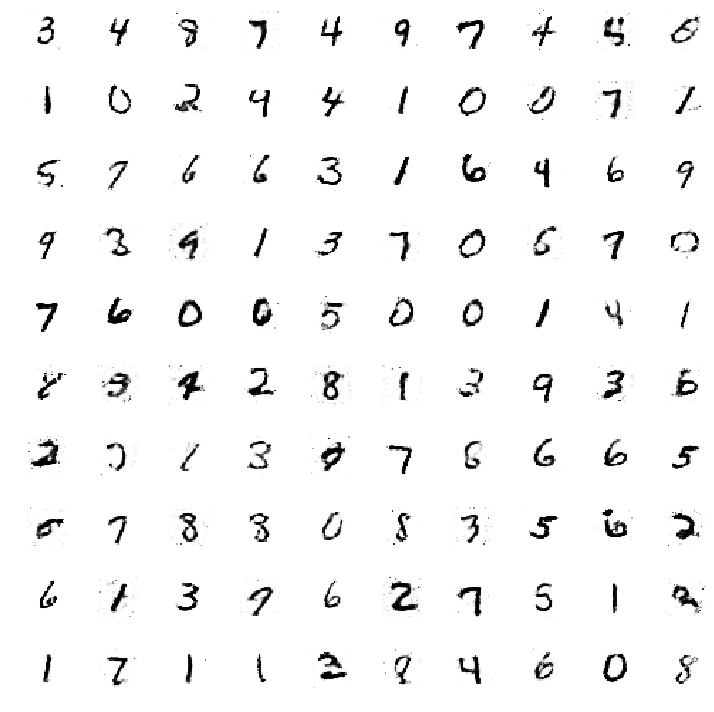

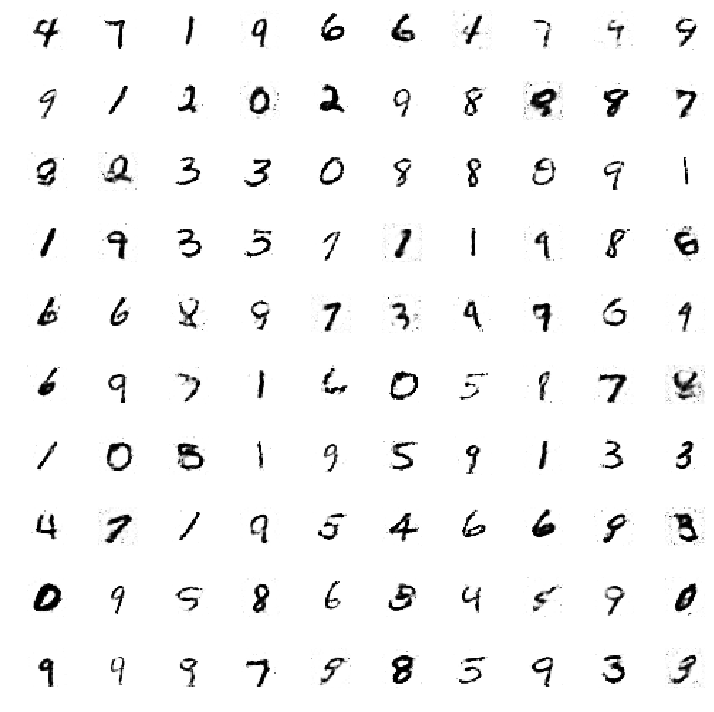

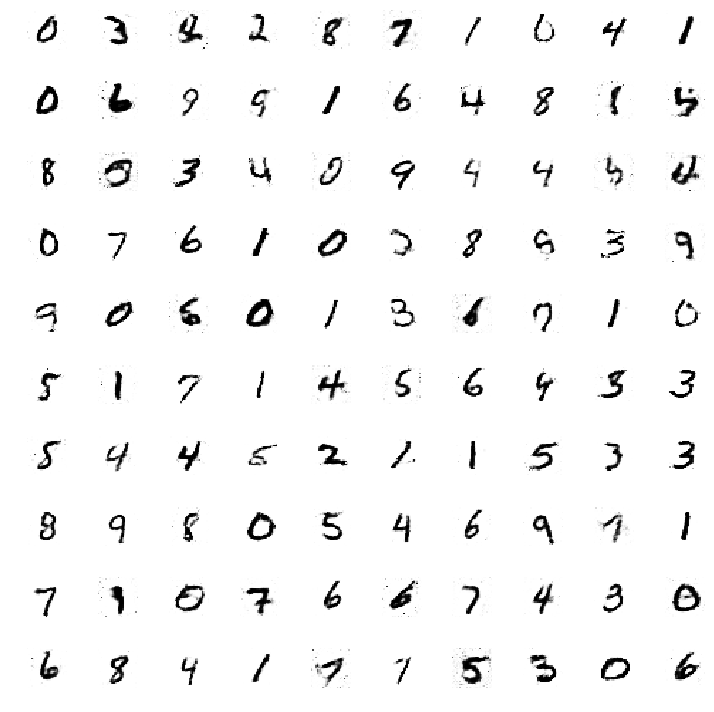

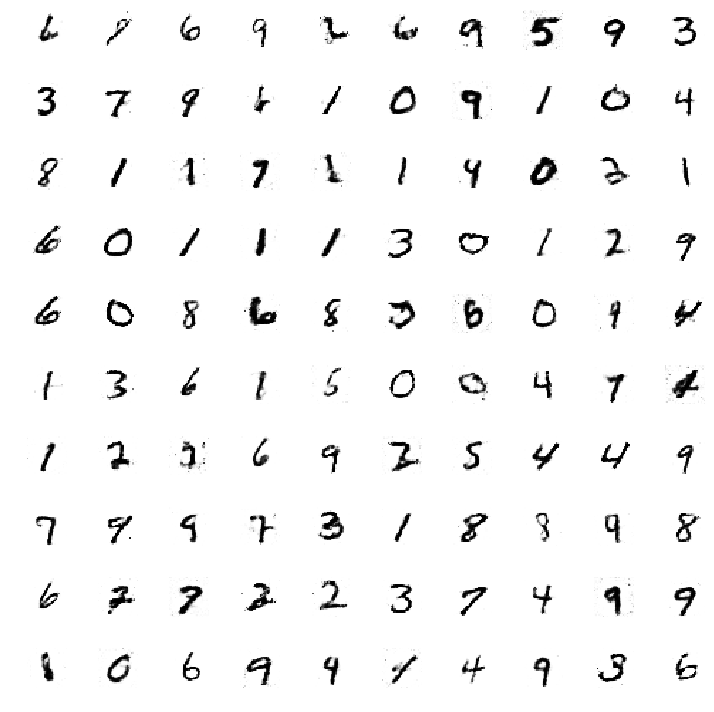

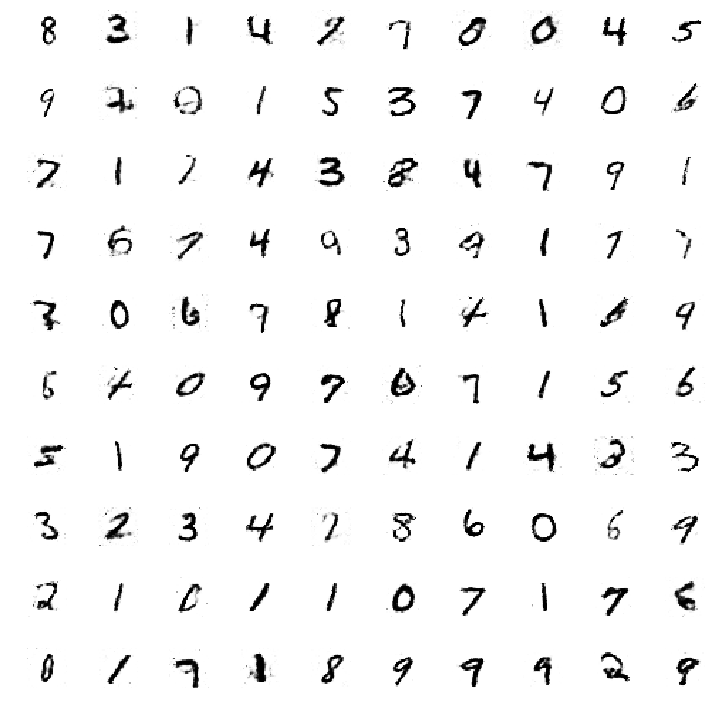

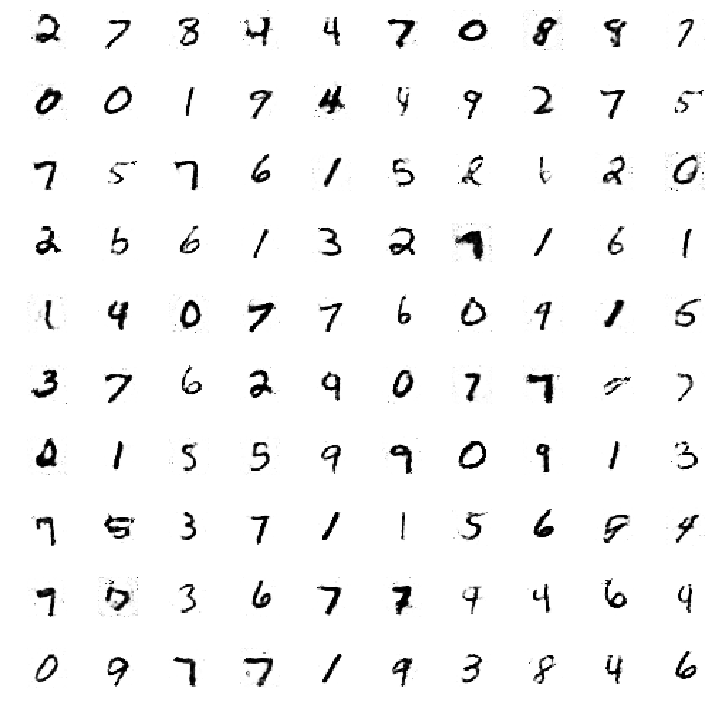

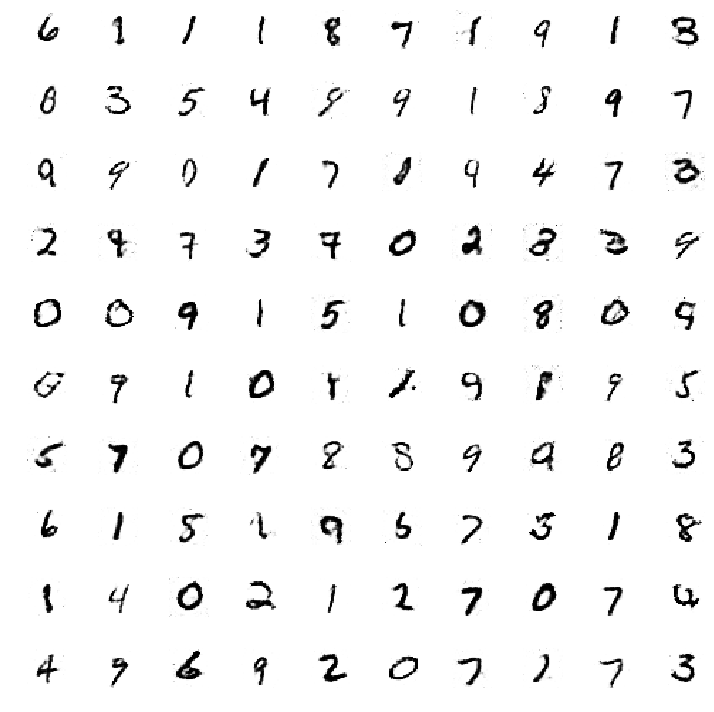

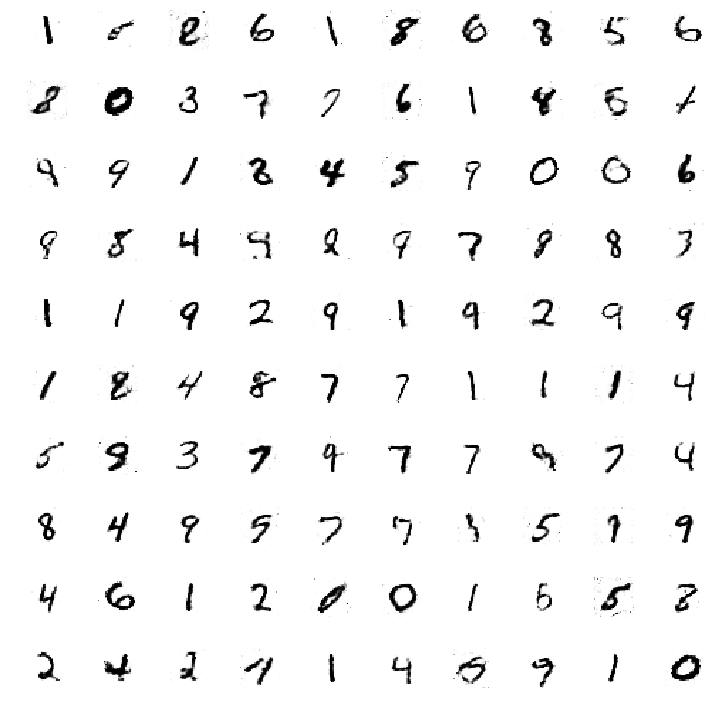

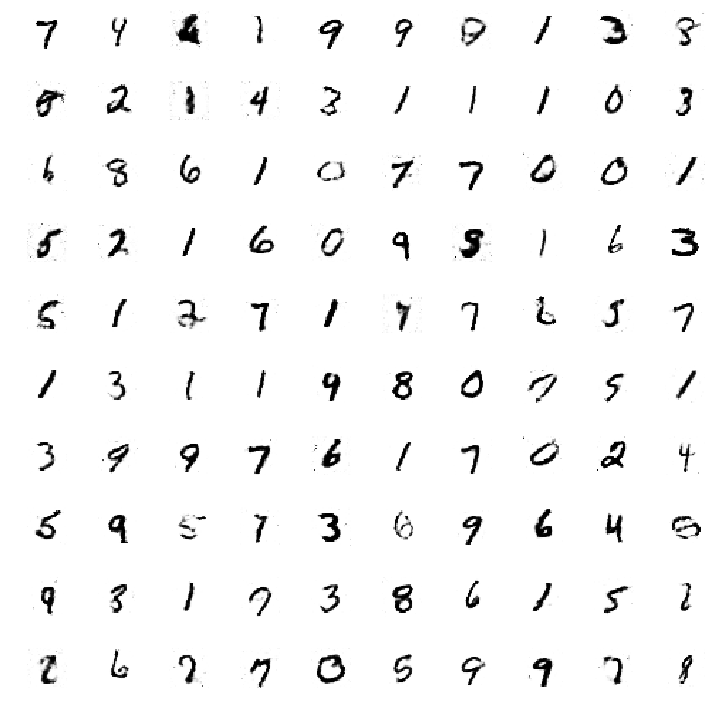

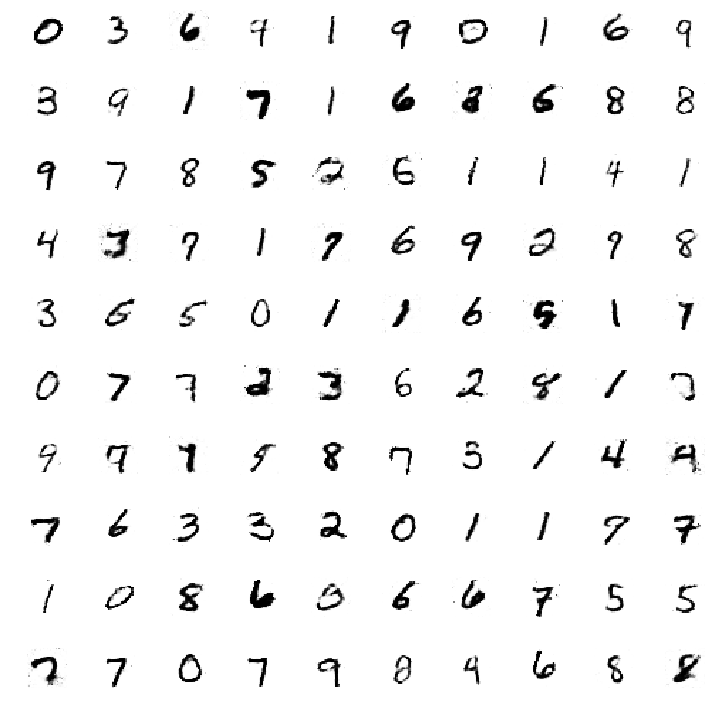

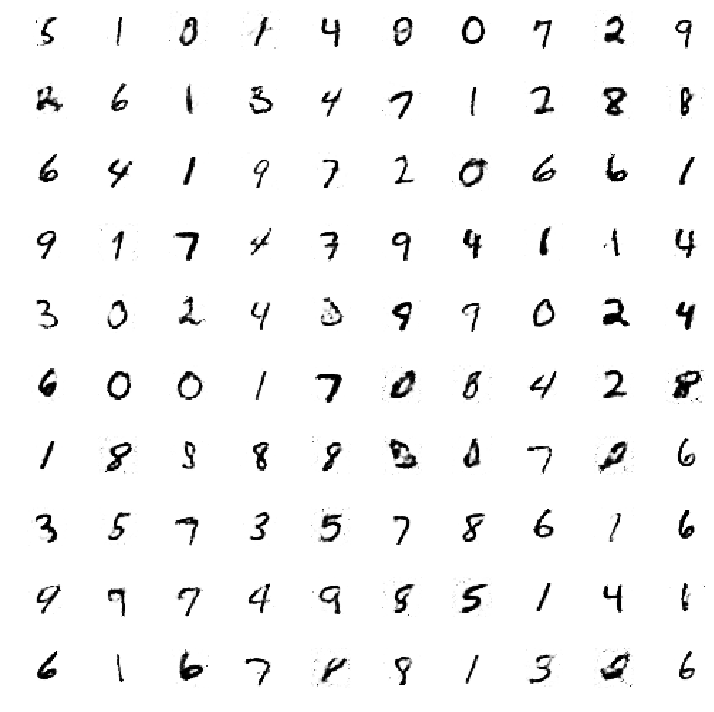

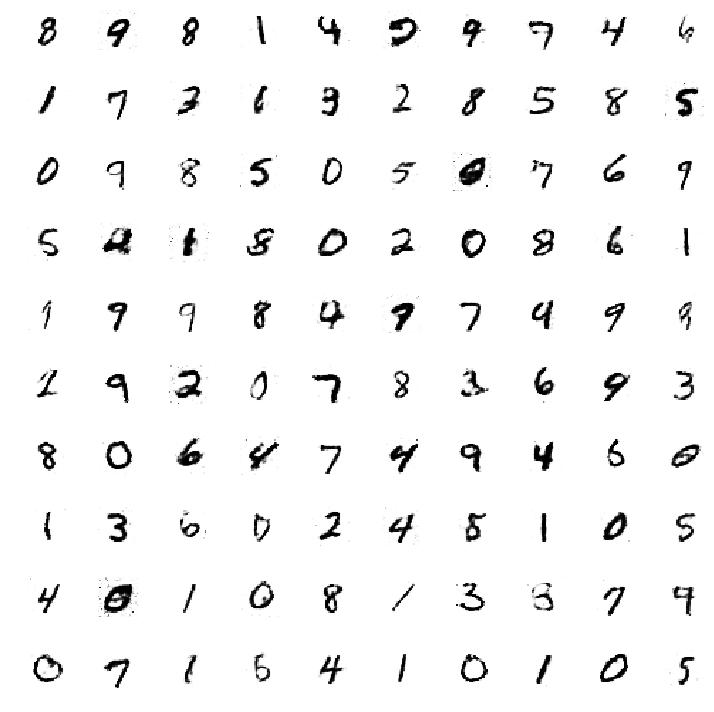

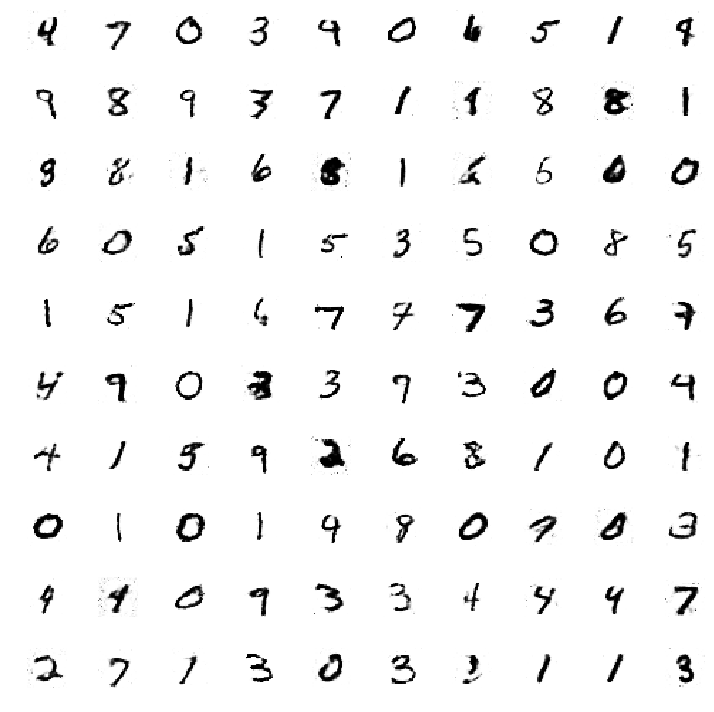

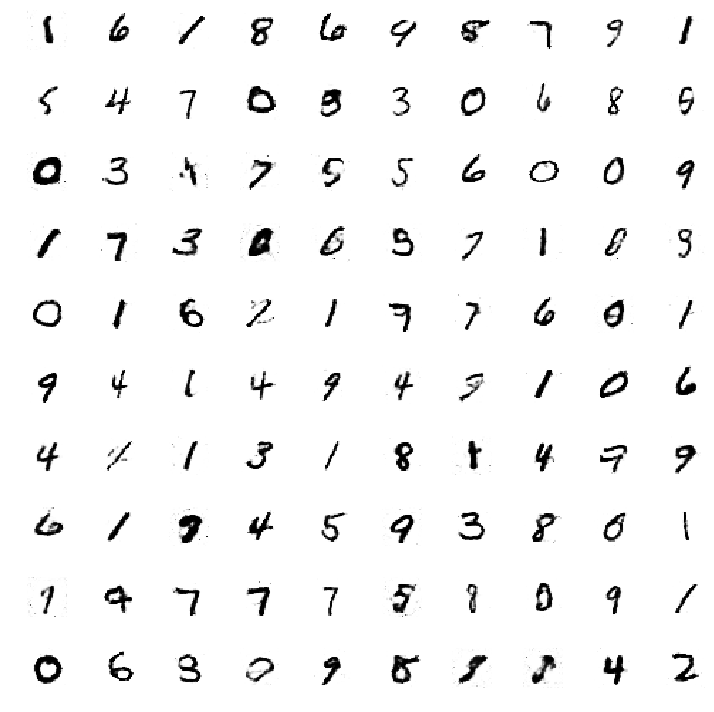

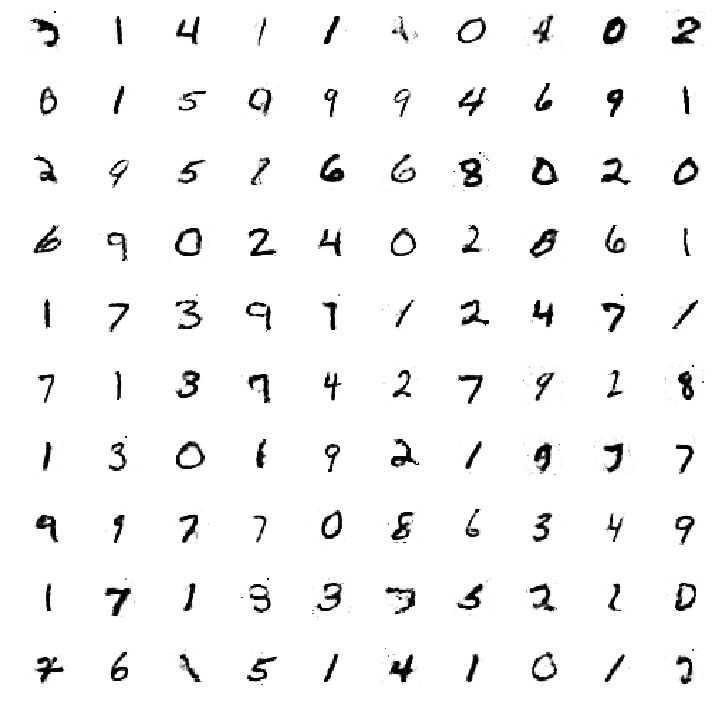

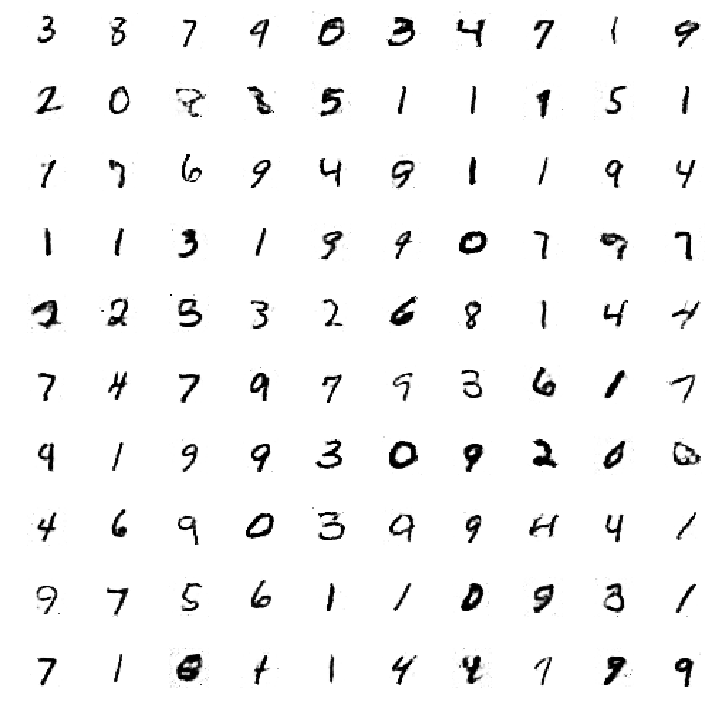

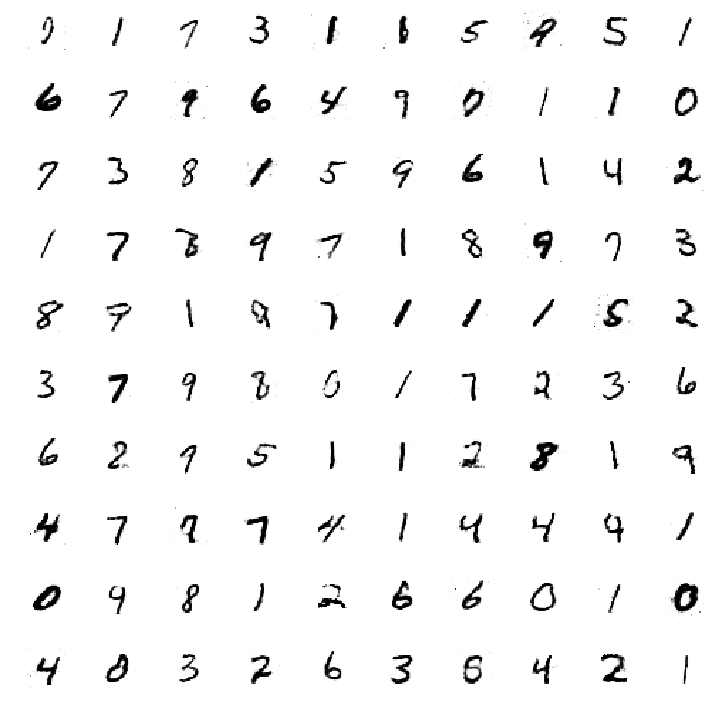

In [15]:
if __name__ == '__main__':
    train(400, 128)